In [30]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [31]:
def sample_details(df):

    first_instance = df.iloc[0]
    print("--- Podaci za prvu instancu ---")
    print(f"Ime fajla: {first_instance['filename']}")
    print(f"Klasa: {first_instance['class']}")
    print(f"Dan: {first_instance['day']}")
    print(f"Oblik (shape) slike: {first_instance['image_shape']}")

    image_array = np.frombuffer(first_instance['image_data'], dtype=np.uint8).reshape(first_instance['image_shape'])

    print(f"Oblik (shape) NumPy niza: {image_array.shape}")
    print(f"Tip podataka: {image_array.dtype}")

In [32]:
# --- 1. Učitavanje podataka ---
def load_and_preprocess_parquet(filepath):
    df = pd.read_parquet(filepath)
    print(f"Učitan DataFrame iz {filepath} sa {len(df)} redova.")
    sample_details(df)

    df['image_array'] = df.apply(
        lambda row: np.frombuffer(row['image_data'], dtype=np.uint8).reshape(row['image_shape']),
        axis=1
    )
    # Možemo obrisati 'image_data'
    df = df.drop(columns=['image_data'])
    return df

In [48]:
def display_random_samples(dataframe, total_samples=10, num_rows=2, num_cols=5):
    """
    Prikazuje fiksni broj nasumičnih uzoraka iz celog skupa podataka (npr. 10),
    raspoređenih u rešetku (npr. 2 reda x 5 kolona).
    
    Pretpostavlja se da DataFrame sadrži kolone: 'image_array', 'class', 'day', i 'filename'.
    """
    
    # Osiguravamo da imamo barem 10 uzoraka
    if len(dataframe) < total_samples:
        print(f"U DataFrame-u ima samo {len(dataframe)} slika. Prikazujem sve dostupne.")
        total_samples = len(dataframe)

    # Odabir 10 nasumičnih indeksa iz celog skupa podataka
    random_indices = random.sample(range(len(dataframe)), total_samples)
    
    # 💡 KLJUČNA IZMENA: Fiksna rešetka 2x5
    fig, axes = plt.subplots(
        nrows=num_rows, 
        ncols=num_cols,
        figsize=(4 * num_cols, 4 * num_rows) # Skaliranje veličine figure
    )
    
    # Flatten axes za lakšu iteraciju
    axes = axes.flatten()
    
    for plot_idx in range(total_samples):
        # Dohvat nasumično odabrane slike
        original_idx = random_indices[plot_idx]
        row = dataframe.iloc[original_idx]
        
        ax = axes[plot_idx]

        # Prikaz slike
        img_array = row['image_array']
        filename = row.get('filename', 'N/A')
        class_val = row['class']
        day_val = row['day']

        if img_array.ndim == 3:
            ax.imshow(img_array)
        else: 
            ax.imshow(img_array, cmap='gray')
            
        ax.set_title(
            f"Klasa: {class_val}, Dan: {day_val}\n{filename[:20]}...", 
            fontsize=10
        )
        ax.axis('off')

    # Sakrivanje viška osa ako je total_samples < num_rows * num_cols
    for i in range(total_samples, len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.suptitle("Slučajni uzorci slika iz celog skupa podataka (10 slika)", y=1.02, fontsize=16)
    plt.show()

In [34]:
def calculate_average_image(dataframe):
    average_images = {}
    classes = sorted(dataframe['class'].unique())
    days = sorted(dataframe['day'].unique())

    for class_val in classes:
        for day_val in days:
            subset = dataframe[(dataframe['class'] == class_val) & (dataframe['day'] == day_val)]
            if subset.empty:
                average_images[(class_val, day_val)] = None
                continue

            # Stack images, then calculate mean along the first axis
            img_list = []
            for img_array in subset['image_array']:
                if img_array.ndim == 2: # Ako je grayscale (H, W)
                    img_list.append(np.expand_dims(img_array, axis=-1)) # Dodaj kanal (H, W, 1)
                elif img_array.ndim == 3 and img_array.shape[2] == 1: # Ako je (H, W, 1)
                     img_list.append(img_array)
                elif img_array.ndim == 3 and img_array.shape[2] == 3: # Ako je (H, W, 3)
                    img_list.append(img_array)
                else:
                    print(f"Upozorenje: Nepodržan oblik slike za Class {class_val}, Day {day_val}: {img_array.shape}")
                    continue

            if not img_list:
                average_images[(class_val, day_val)] = None
                continue

            stacked_images = np.stack(img_list, axis=0) # Stack na (N, H, W, C)
            
            avg_img = np.mean(stacked_images, axis=0)

            avg_img = (avg_img - avg_img.min()) / (avg_img.max() - avg_img.min()) * 255
            avg_img = avg_img.astype(np.uint8)

            if avg_img.shape[-1] == 1:
                avg_img = avg_img.squeeze(axis=-1)


            average_images[(class_val, day_val)] = avg_img
    return average_images

In [50]:
def display_average_images(avg_imgs_dict):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 10)) 
    axes = axes.flatten()
    plot_idx = 0

    for (class_val, day_val) in sorted(avg_imgs_dict.keys()):
        
        if plot_idx >= len(axes):
            break
            
        avg_img = avg_imgs_dict[(class_val, day_val)]
        
        if avg_img is not None:
            # Prikaz slike
            if avg_img.ndim == 2: # Grayscale (H, W)
                axes[plot_idx].imshow(avg_img, cmap='gray')
            else: # RGB (H, W, C)
                axes[plot_idx].imshow(avg_img)
                
            axes[plot_idx].set_title(f"Pros. Klasa: {class_val}, Dan: {day_val}")
            axes[plot_idx].axis('off')
        else:
            # Prikaz poruke ako nema podataka
            axes[plot_idx].axis('off')
            axes[plot_idx].text(0.5, 0.5, f'Nema podataka\nKlasa {class_val}, Dan {day_val}',
                                horizontalalignment='center', verticalalignment='center',
                                transform=axes[plot_idx].transAxes, color='red')
            
        plot_idx += 1

    plt.tight_layout()
    # Postavljanje naslova iznad cele figure
    plt.suptitle("Prosečne slike po klasi i danu razvitka", y=1.02, fontsize=16)
    plt.show()

In [36]:
def display_difference_heatmaps(avg_imgs_dict):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6)) # 3 mape razlika
    axes = axes.flatten()
    plot_idx = 0

    # Razlika između Klasa 0 i 1 za Dan 3
    avg_k0_d3 = avg_imgs_dict.get((0, 3))
    avg_k1_d3 = avg_imgs_dict.get((1, 3))
    if avg_k0_d3 is not None and avg_k1_d3 is not None and avg_k0_d3.shape == avg_k1_d3.shape:
        diff_d3 = np.abs(avg_k1_d3.astype(float) - avg_k0_d3.astype(float))
        im = axes[plot_idx].imshow(diff_d3.mean(axis=-1) if diff_d3.ndim == 3 else diff_d3, cmap='hot')
        axes[plot_idx].set_title("Razlika (K1 vs K0) na Danu 3")
        axes[plot_idx].axis('off')
        fig.colorbar(im, ax=axes[plot_idx], fraction=0.046, pad=0.04)
        plot_idx += 1
    else:
        axes[plot_idx].axis('off')
        axes[plot_idx].text(0.5, 0.5, 'Nema podataka za razliku\nK1 vs K0, Dan 3', horizontalalignment='center', verticalalignment='center', transform=axes[plot_idx].transAxes)
        plot_idx += 1


    # Razlika između Klasa 0 i 1 za Dan 5
    avg_k0_d5 = avg_imgs_dict.get((0, 5))
    avg_k1_d5 = avg_imgs_dict.get((1, 5))
    if avg_k0_d5 is not None and avg_k1_d5 is not None and avg_k0_d5.shape == avg_k1_d5.shape:
        diff_d5 = np.abs(avg_k1_d5.astype(float) - avg_k0_d5.astype(float))
        im = axes[plot_idx].imshow(diff_d5.mean(axis=-1) if diff_d5.ndim == 3 else diff_d5, cmap='hot')
        axes[plot_idx].set_title("Razlika (K1 vs K0) na Danu 5")
        axes[plot_idx].axis('off')
        fig.colorbar(im, ax=axes[plot_idx], fraction=0.046, pad=0.04)
        plot_idx += 1
    else:
        axes[plot_idx].axis('off')
        axes[plot_idx].text(0.5, 0.5, 'Nema podataka za razliku\nK1 vs K0, Dan 5', horizontalalignment='center', verticalalignment='center', transform=axes[plot_idx].transAxes)
        plot_idx += 1

    # Razlika između Dana 3 i Dana 5 za Klasu 0 (možeš dodati i za Klasu 1)
    avg_k0_d3 = avg_imgs_dict.get((0, 3))
    avg_k0_d5 = avg_imgs_dict.get((0, 5))
    if avg_k0_d3 is not None and avg_k0_d5 is not None and avg_k0_d3.shape == avg_k0_d5.shape:
        diff_day_k0 = np.abs(avg_k0_d5.astype(float) - avg_k0_d3.astype(float))
        im = axes[plot_idx].imshow(diff_day_k0.mean(axis=-1) if diff_day_k0.ndim == 3 else diff_day_k0, cmap='hot')
        axes[plot_idx].set_title("Razlika (Dan 5 vs Dan 3) za Klasu 0")
        axes[plot_idx].axis('off')
        fig.colorbar(im, ax=axes[plot_idx], fraction=0.046, pad=0.04)
        plot_idx += 1
    else:
        axes[plot_idx].axis('off')
        axes[plot_idx].text(0.5, 0.5, 'Nema podataka za razliku\nDan 5 vs Dan 3, Klasa 0', horizontalalignment='center', verticalalignment='center', transform=axes[plot_idx].transAxes)
        plot_idx += 1

    plt.tight_layout()
    plt.suptitle("Mape toplote razlika između prosečnih slika", y=1.02, fontsize=16)
    plt.show()

In [37]:
def calculate_image_brightness(image_array):
    """
    Izračunava prosečnu osvetljenost (luminancu) slike.
    Za RGB slike, konvertuje u grayscale pre izračunavanja.
    """
    if image_array.ndim == 3: # RGB ili RGBA
        # Konverzija u grayscale (luminanca)
        # Standardni koeficijenti za luminancu: 0.2989*R + 0.5870*G + 0.1140*B
        if image_array.shape[2] == 3: # RGB
            grayscale_img = np.dot(image_array[...,:3], [0.2989, 0.5870, 0.1140])
        elif image_array.shape[2] == 4: # RGBA, ignorišemo alfa kanal
            grayscale_img = np.dot(image_array[...,:3], [0.2989, 0.5870, 0.1140])
        else: # Nepodržan broj kanala
            return np.nan
    elif image_array.ndim == 2: # Grayscale
        grayscale_img = image_array
    else:
        return np.nan
    return np.mean(grayscale_img)

In [38]:
def plot_brightness_distribution(dataframe):
    dataframe['brightness'] = dataframe['image_array'].apply(calculate_image_brightness)

    plt.figure(figsize=(10, 6))
    sns.boxplot(data=dataframe, x='class', y='brightness', hue='day', palette='viridis')
    plt.title("Raspodela Prosečne Osvetljenosti Slike po Klasi i Danu Razvitka")
    plt.xlabel("Klasa Embriona")
    plt.ylabel("Prosečna Osvetljenost Piksela")
    plt.legend(title="Dan Razvitka")
    plt.tight_layout()
    plt.show()

    g = sns.FacetGrid(dataframe, col='day', hue='class', palette='coolwarm', col_wrap=2, height=5, aspect=1.2)
    g.map(sns.histplot, 'brightness', kde=True, common_bins=True, common_norm=False, multiple="stack")
    g.add_legend(title="Klasa")
    g.set_axis_labels("Prosečna osvetljenost piksela", "Broj slika")
    g.set_titles("Dan razvitka: {col_name}")
    plt.suptitle("Histogram osvetljenosti slike po klasi i danu razvitka", y=1.02, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
    plt.show()

In [52]:
parquet_file_path = '../prepared_data/test_images.parquet' 
try:
    df_images = load_and_preprocess_parquet(parquet_file_path)
except FileNotFoundError:
    print(f"Greška: Fajl '{parquet_file_path}' nije pronađen. Molimo proverite putanju.")
    exit()

# --- 2. Vizualizacija ---

# Postavljanje stilova za grafikone
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8) # Podrazumevana veličina grafika

Učitan DataFrame iz ../prepared_data/test_images.parquet sa 672 redova.
--- Podaci za prvu instancu ---
Ime fajla: D5_393_52e0bc4ed3054be49e8d04ce9ec681f1.jpg
Klasa: 0
Dan: 5
Oblik (shape) slike: [512, 512, 3]
Oblik (shape) NumPy niza: (512, 512, 3)
Tip podataka: uint8



--- Pokretanje Vizualizacija ---


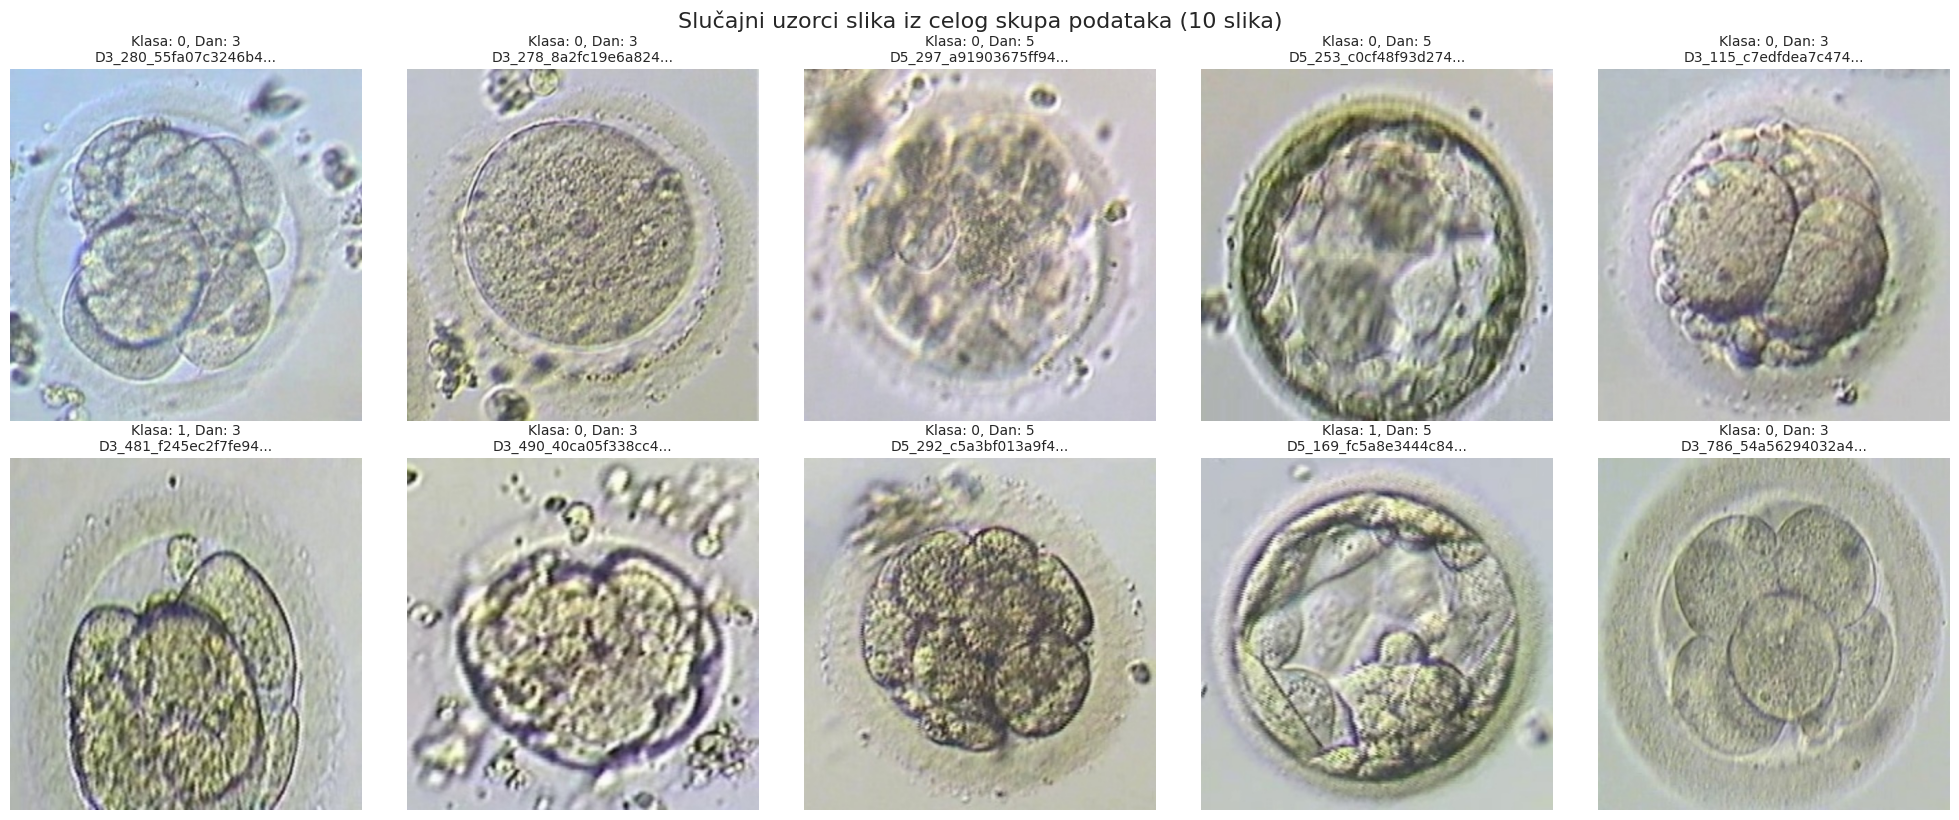

In [49]:
print("\n--- Pokretanje Vizualizacija ---")
display_random_samples(df_images)

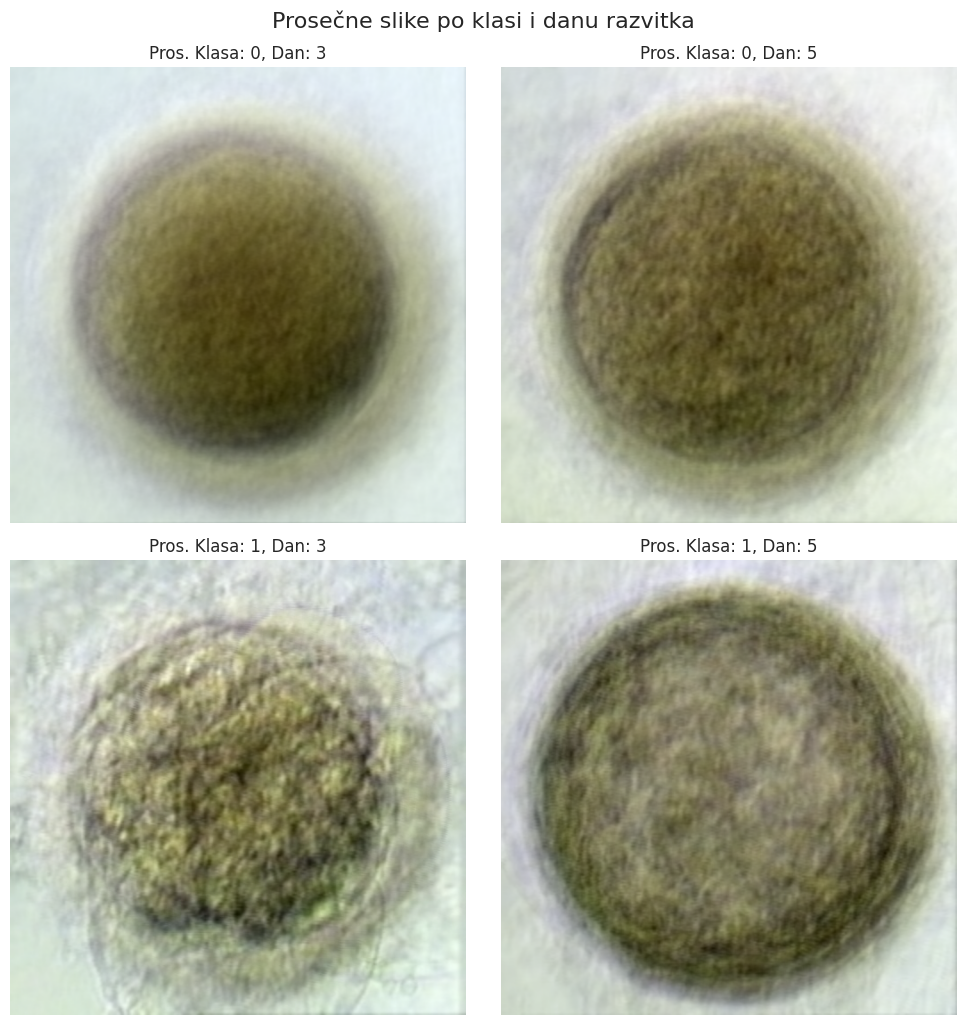

In [51]:
avg_images = calculate_average_image(df_images)
display_average_images(avg_images)

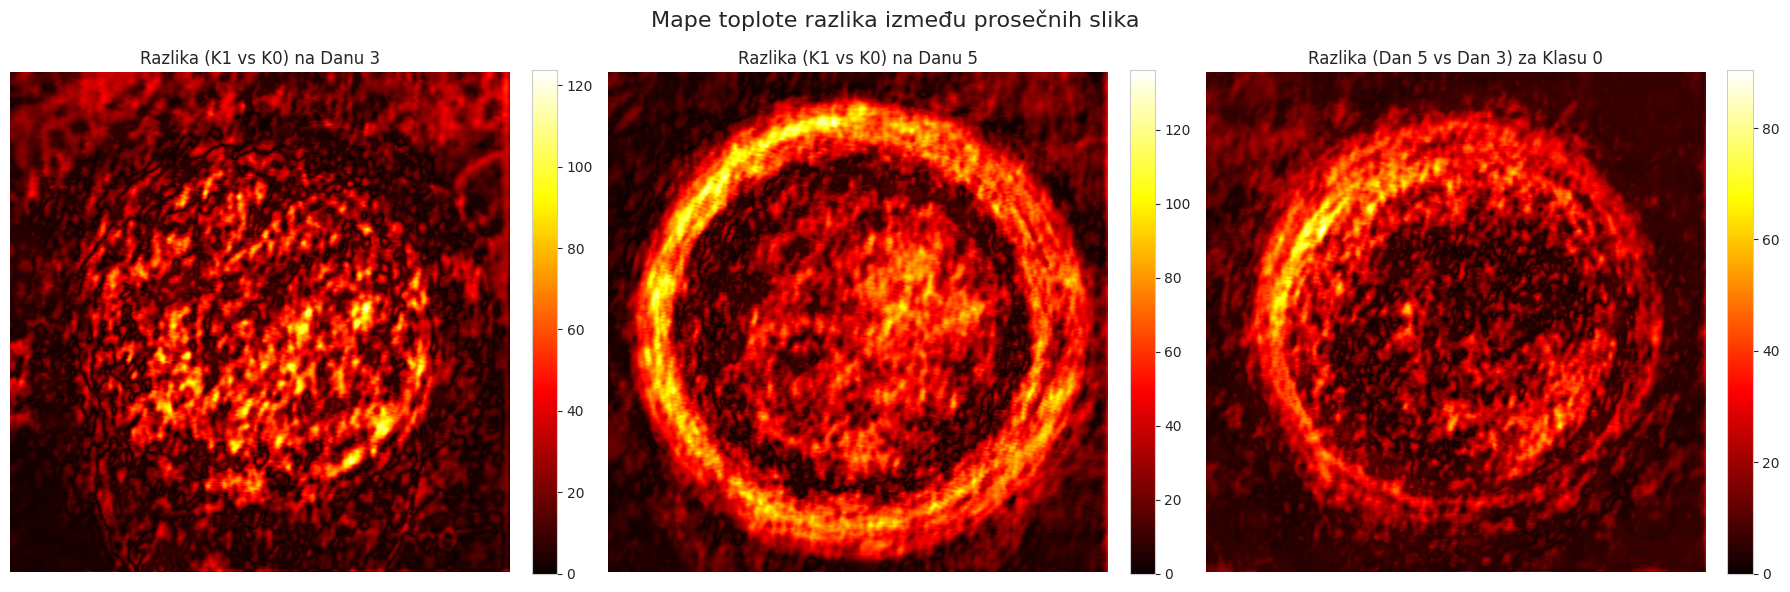

In [42]:
display_difference_heatmaps(avg_images)

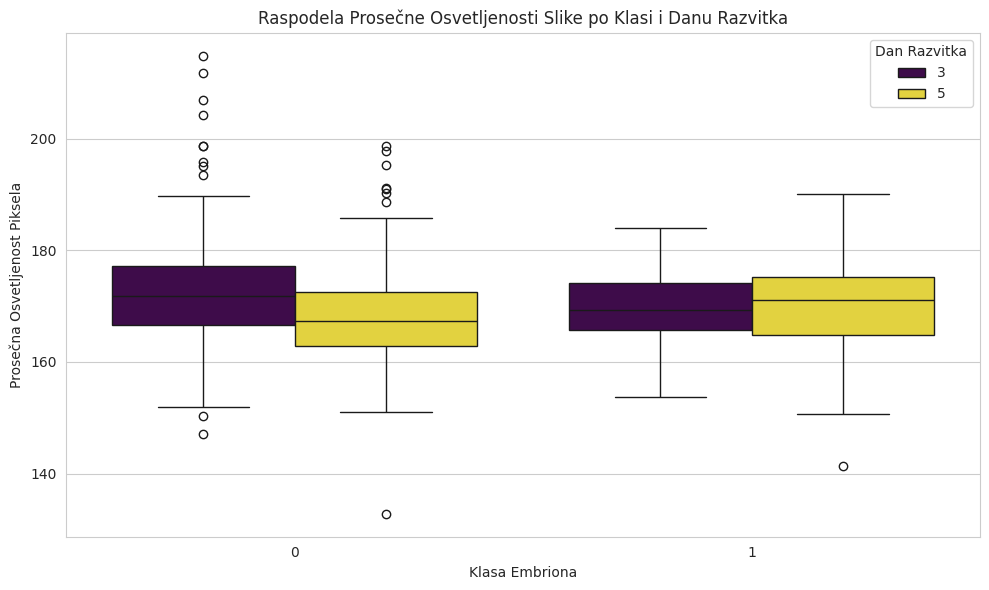

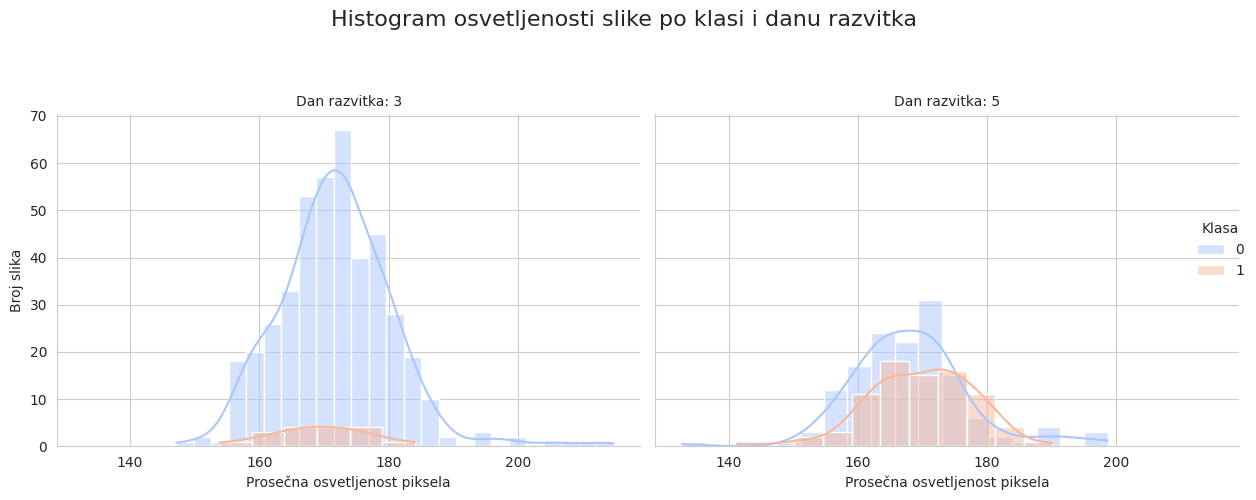


Vizualizacije završene!


In [43]:
plot_brightness_distribution(df_images)

print("\nVizualizacije završene!")